In [184]:
import geopandas as gpd
import requests
import time
import shapely
import geopandas_osm.osm
import numpy as np
import descartes
import math
%matplotlib inline

In [185]:
leftbound = -75.5898
rightbound = -75.5740
upperbound = 40.1391
lowerbound = 40.1134
bbox = [(leftbound,lowerbound ), (rightbound,lowerbound), (rightbound,upperbound), (leftbound,upperbound)]
df = geopandas_osm.osm.query_osm('way', Polygon(bbox), recurse='down')


In [186]:
arr=["highway","residential", "primary", "secondary","tertiary","unclassified", "cycleway"]
df=df[df.highway.isin(arr)]
df["geometry"]


2     LINESTRING (-75.582399 40.128127, -75.581869 4...
3     LINESTRING (-75.588481 40.140452, -75.588418 4...
4     LINESTRING (-75.58474200000001 40.12023, -75.5...
5     LINESTRING (-75.58092000000001 40.130136, -75....
6     LINESTRING (-75.585381 40.132703, -75.585033 4...
7     LINESTRING (-75.589359 40.117143, -75.58929500...
8     LINESTRING (-75.5783229 40.1306533, -75.578250...
9     LINESTRING (-75.58195499999999 40.133631, -75....
10    LINESTRING (-75.578626 40.134604, -75.57861200...
12    LINESTRING (-75.583094 40.112462, -75.58320500...
13    LINESTRING (-75.58058800000001 40.123706, -75....
14    LINESTRING (-75.580197 40.128909, -75.581074 4...
15    LINESTRING (-75.580426 40.124818, -75.58059 40...
17    LINESTRING (-75.58511799999999 40.130374, -75....
18    LINESTRING (-75.579583 40.113681, -75.57960199...
19    LINESTRING (-75.58516299999999 40.129724, -75....
20    LINESTRING (-75.572425 40.136861, -75.573086 4...
21    LINESTRING (-75.58092000000001 40.130136, 

In [284]:
newdata = gpd.GeoDataFrame()
newdata["street name"]=None
newdata["geometry"]=None
streetnewdata = gpd.GeoDataFrame()
streetnewdata["street name"]=None
streetnewdata["geometry"]=None

In [257]:
elevations = dict()

In [256]:
print elevations

{}


In [189]:
all_coords_list = []
for geometry in df["geometry"]:
    for coord in geometry.coords:
        all_coords_list.append(coord)

In [274]:
def is_intersection(val):
    num_matches = 0
    for i in all_coords_list:
        if val == i:
            num_matches +=1
    
    if(num_matches > 1):
        return True
    else:
        return False

def get_elev_diff(point1, point2):
        return get_elev(point1)-get_elev(point2)
def get_elev(point):
    if(point in elevations):
        return elevations[point]
    else:
        rqstring = "https://maps.googleapis.com/maps/api/elevation/json?locations="+str(point[0])+","+str(point[1])
        elevation=requests.get(rqstring)
        elev = elevation.json()["results"][0]["elevation"]
        elevations[point] = elev
        time.sleep(.1)
        return elev
def distance(point1, point2):
    return math.hypot(point2[0]-point1[0], point2[1]-point1[1])
def dot(a, b):
    return (a[0]*b[0])+(a[1]+b[1])
def get_vector(point, origin):
    return (point[0]-origin[0], point[1]-origin[1])
def get_anchor_point(point1, point2, elev_diff):
    if(elev_diff == 0):
        return False
    theta = math.atan(elev_diff/float(distance(point1, point2)))
    vertical_offset = math.sin(theta)*float(distance(point1, point2))
    horizontal_offset = math.sin(math.acos(vertical_offset/elev_diff))*elev_diff
    return (point1[0]-horizontal_offset, point1[1]-vertical_offset)

def get_baseline_angle(anchor, other):
    return math.atan((other[1]-anchor[1])/(other[0]-anchor[0]))

In [275]:
#if you want to save the elevation diffs in a .npy file so you don't have to query the elevation api every time use this
#elev_diff_list = np.load("philly_elev_diffs.npy")
#elev_diff_list = [i*10 for i in elev_diff_list]

In [311]:
new_index = -1
for index, name, geometry in zip(df.index.values, df["name"],df["geometry"]):
    new_index +=1
    coords = geometry.coords
    coords_list = [i for i in coords]
    intersection_list = [coords[0]]
    index=0
    for coord in coords[1:-1]:
        index+=1
        if(is_intersection(coord)):
            #print "true"
            intersection_list.append(index)
    intersection_list.append(coords[-1])

    prev_index = 0    
    if(len(intersection_list) > 2):
        for i in intersection_list[1:-1]:
            #print "section from point ", coords[prev_index], "to point", coords[i], ":",
            point1 = coords[prev_index]
            point2 = coords[i]
            elev1 = get_elev(point1)
            elev2 = get_elev(point2)
            elev_diff=round((elev1-elev2)*.00001,7)
            baseline_angle = 0
            anchor_point = get_anchor_point(point1, point2, elev_diff)
            
            if(elev_diff > 0):
                anchor_point = get_anchor_point(point2, point1, elev_diff)
                point1, point2 = point2, point1
            if(anchor_point != False):
                baseline_angle = get_baseline_angle(anchor_point, point1)
            else:
                anchor_point = point1
            seg_arr = coords_list[prev_index:i]
            new_points = []
            for point in seg_arr[1:]:
                a = get_vector(point, anchor_point)
                b = get_vector(point2, anchor_point)
                c = dot(a, b)/dot(b, b)
                c = (c*b[0], c*b[1])
                p = (anchor_point[0]+c[0], anchor_point[1]+c[1])
                new_points.append(p)
            new_points.insert(0,seg_arr[0])
            seg_arr = new_points
            if(anchor_point !=False):
                seg_arr.append(anchor_point)
            prev_index = i
            
            
            
    else:
        #print "section from point ", intersection_list[0], "to point", intersection_list[1], ":",
        elev_diff=round(get_elev_diff(intersection_list[0], intersection_list[1])*.00001,7)
        seg_arr = coords_list  
        anchor = get_anchor_point(intersection_list[0],intersection_list[1], elev_diff)
        seg_arr.append(anchor) if anchor !=False else seg_arr.append((seg_arr[0][0],seg_arr[0][1]-elev_diff))
        #if(elev_diff < 0):
        #        seg_arr.append((seg_arr[0][0],seg_arr[0][1]-elev_diff))
        #else:
                #seg_arr.append((seg_arr[-1][0],seg_arr[-1][1]-elev_diff))
        #print(elev_diff, seg_arr)
        #print "New seg_arr", seg_arr
    
    if(len(seg_arr) > 2):
        poly = Polygon(seg_arr)
        line = LineString(seg_arr[:-1])
        try:
            streetnewdata.loc[new_index, "geometry"] = line
            streetnewdata.loc[new_index, "street name"] = name
            newdata.loc[new_index, "geometry"] = poly
            newdata.loc[new_index, "street name"] = name
        except:
            continue

In [312]:
streetnewdata["geometry"]



0     LINESTRING (-75.581074 40.129278, -75.58092890...
1     LINESTRING (-75.588481 40.140452, -75.588418 4...
2     LINESTRING (-75.58474200000001 40.12023, -75.5...
3     LINESTRING (-75.58092000000001 40.130136, -75....
4     LINESTRING (-75.58195499999999 40.133631, -75....
5     LINESTRING (-75.589359 40.117143, -75.58929500...
6     LINESTRING (-75.576695 40.129267, -75.57662285...
7     LINESTRING (-75.58195499999999 40.133631, -75....
8     LINESTRING (-75.578626 40.134604, -75.57861200...
9     LINESTRING (-75.583094 40.112462, -75.58320500...
10    LINESTRING (-75.577963 40.128564, -75.57716553...
12    LINESTRING (-75.580426 40.124818, -75.58128194...
13    LINESTRING (-75.58511799999999 40.130374, -75....
14    LINESTRING (-75.579583 40.113681, -75.58147278...
15    LINESTRING (-75.58516299999999 40.129724, -75....
16    LINESTRING (-75.572425 40.136861, -75.573086 4...
17    LINESTRING (-75.58092000000001 40.130136, -75....
18    LINESTRING (-75.583933 40.130885, -75.5845

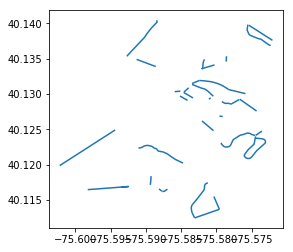

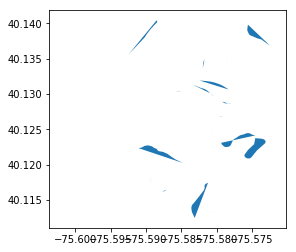

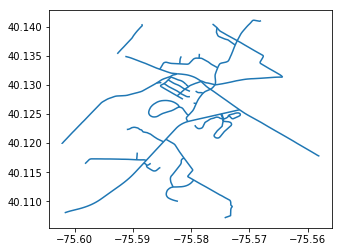

In [313]:
streetnewdata.plot()
newdata.plot()
df.plot()

In [196]:
newdata.to_file("out_map.shp")
streetnewdata.to_file("out_street_map.shp")
